# Analisis Peramalan Jumlah Permintaan Produk Toko dengan metode SARIMA dan Prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)


In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series

    Args:
        time_series (df): Dataframe of univariate time series
        max_d (int): Max value of how many times apply difference

    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times
        differencing on a time-series.

    """

    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True

        stationary = adf_stationary & kpss_stationary

        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))

    # Construct DataFrame
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])

    return results_df


In [4]:
df_train = pd.read_csv("train.csv")
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df_test = pd.read_csv("test.csv")
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
df_test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


### Exploratory Data Analysis

In [10]:
df_train.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
df_test.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

As we can see, both train and test datasets have 10 stores and each store offers 50 unique items.
`sales` is our target.

In [12]:
# Change dtype of date to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [13]:
print("Period covered in train dataset:", df_train['date'].min(),df_train['date'].max())
print("Period covered in test dataset:", df_test['date'].min(),df_test['date'].max())

Period covered in train dataset: 2013-01-01 00:00:00 2017-12-31 00:00:00
Period covered in test dataset: 2018-01-01 00:00:00 2018-03-31 00:00:00


Dataset pelatihan mencakup data dari 1 Januari 2013 hingga 31 Desember 2017. Tujuan dari penelitian ini adalah untuk memprediksi penjualan barang di semua toko selama periode 1 Januari 2018 hingga 31 Maret 2018, atau selama 3 bulan.

In [14]:
df_train[['store','sales']].groupby('store').sum().sort_values('sales', ascending=False)

,sales
store,
2,6120128
8,5856169
3,5435144
10,5360158
9,5025976
4,5012639
1,4315603
5,3631016
6,3627670


<Axes: title={'center': 'Number of sales per store.'}, xlabel='store', ylabel='sales'>

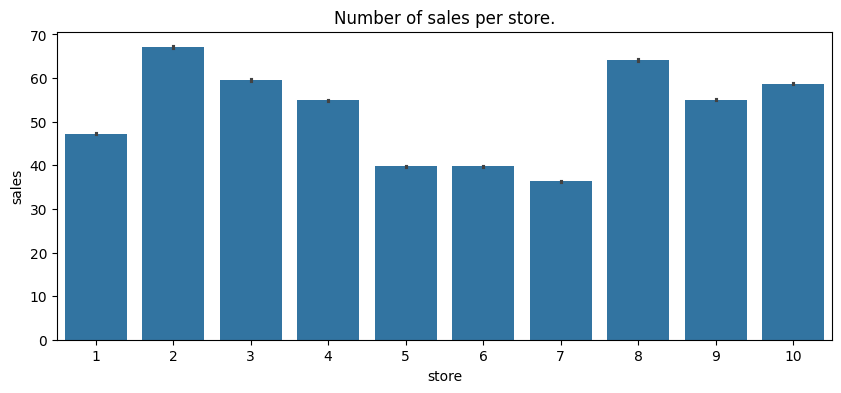

In [15]:
plt.figure(figsize=(10,4))
plt.title("Number of sales per store.")
sns.barplot(data=df_train,x='store',y='sales')

In [16]:
df_store_2 = df_train[df_train['store']==2]

df_store_2

,date,store,item,sales
1826,2013-01-01,2,1,12
1827,2013-01-02,2,1,16
1828,2013-01-03,2,1,16
1829,2013-01-04,2,1,20
1830,2013-01-05,2,1,16
...,...,...,...,...
898387,2017-12-27,2,50,79
898388,2017-12-28,2,50,68
898389,2017-12-29,2,50,67
898390,2017-12-30,2,50,79


In [17]:
df_store_2 = df_store_2[['date','item','sales']]

In [18]:
df_store_2[['item','sales']].groupby('item').sum().sort_values('sales', ascending=False)[:10]

,sales
item,
28,205677
15,205569
18,197422
13,197031
25,188856
45,188774
38,188533
22,188096
8,180939


<Axes: title={'center': 'Number of sales per item in Store 2.'}, xlabel='item', ylabel='sales'>

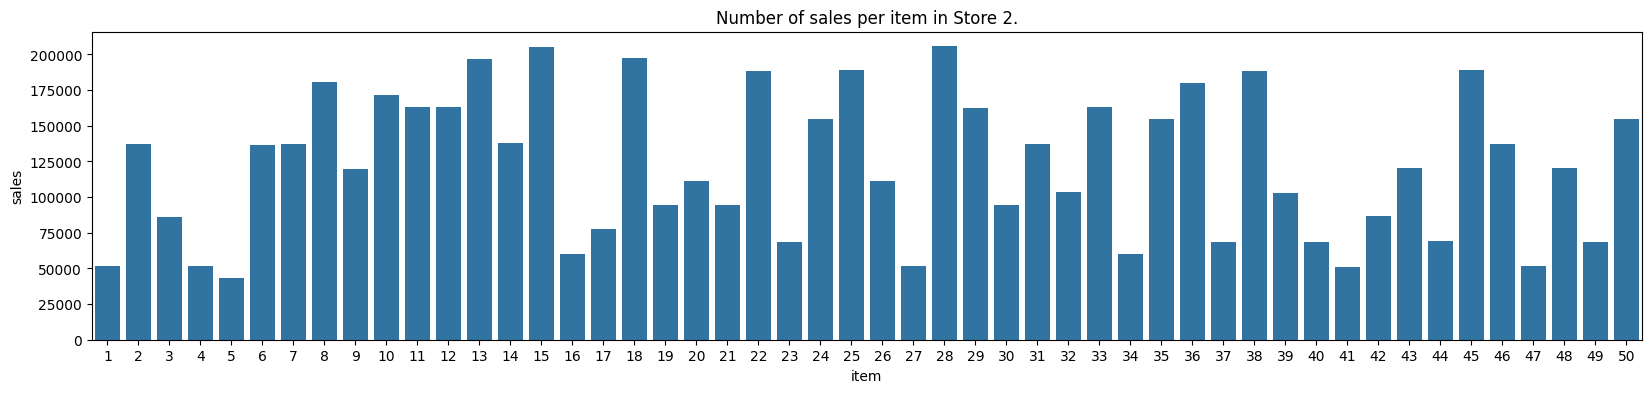

In [19]:
plt.figure(figsize=(20,4))
plt.title("Number of sales per item in Store 2.")
sns.barplot(data=df_store_2[['item','sales']].groupby('item').sum().reset_index(),x='item',y='sales')

In [20]:
# create some time related columns

df_store_2['year'] = df_store_2['date'].dt.year
df_store_2['month'] = df_store_2['date'].dt.month
df_store_2['day'] = df_store_2['date'].dt.dayofyear
df_store_2['weekday'] = df_store_2['date'].dt.weekday
df_store_2['year-month'] = df_store_2['date'].apply(lambda x: str(x.year)+'-'+str(x.month))

In [21]:
df_store_2.head()

,date,item,sales,year,month,day,weekday,year-month
1826,2013-01-01,1,12,2013,1,1,1,2013-1
1827,2013-01-02,1,16,2013,1,2,2,2013-1
1828,2013-01-03,1,16,2013,1,3,3,2013-1
1829,2013-01-04,1,20,2013,1,4,4,2013-1
1830,2013-01-05,1,16,2013,1,5,5,2013-1


<Axes: title={'center': 'Sales per week day.'}, xlabel='weekday', ylabel='sales'>

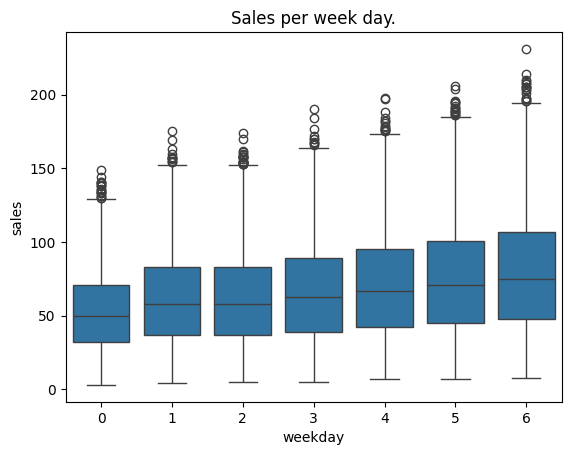

In [22]:
plt.title("Sales per week day.")
sns.boxplot(x="weekday", y="sales", data=df_store_2)


Penjualan yang lebih tinggi terjadi selama akhir pekan (5=Sabtu, 6=Minggu). Terdapat outlier pada semua hari.

<Axes: title={'center': 'Sales per month.'}, xlabel='month', ylabel='sales'>

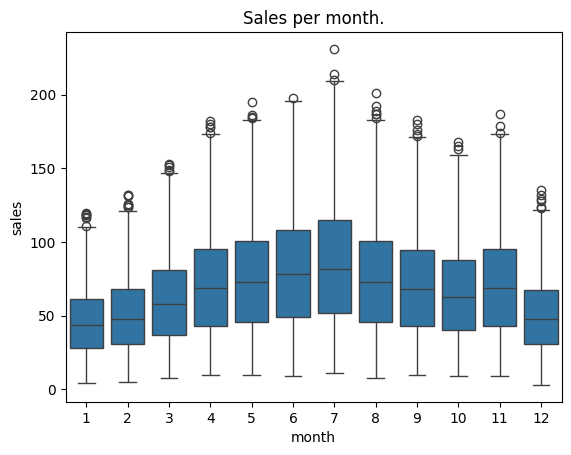

In [23]:
plt.title("Sales per month.")
sns.boxplot(x="month", y="sales", data=df_store_2)

Volume penjualan tertinggi dicapai pada bulan Juli, sementara volume terendah terjadi pada bulan Januari.

<Axes: title={'center': 'Sales per Year-Month'}, xlabel='year-month', ylabel='sales'>

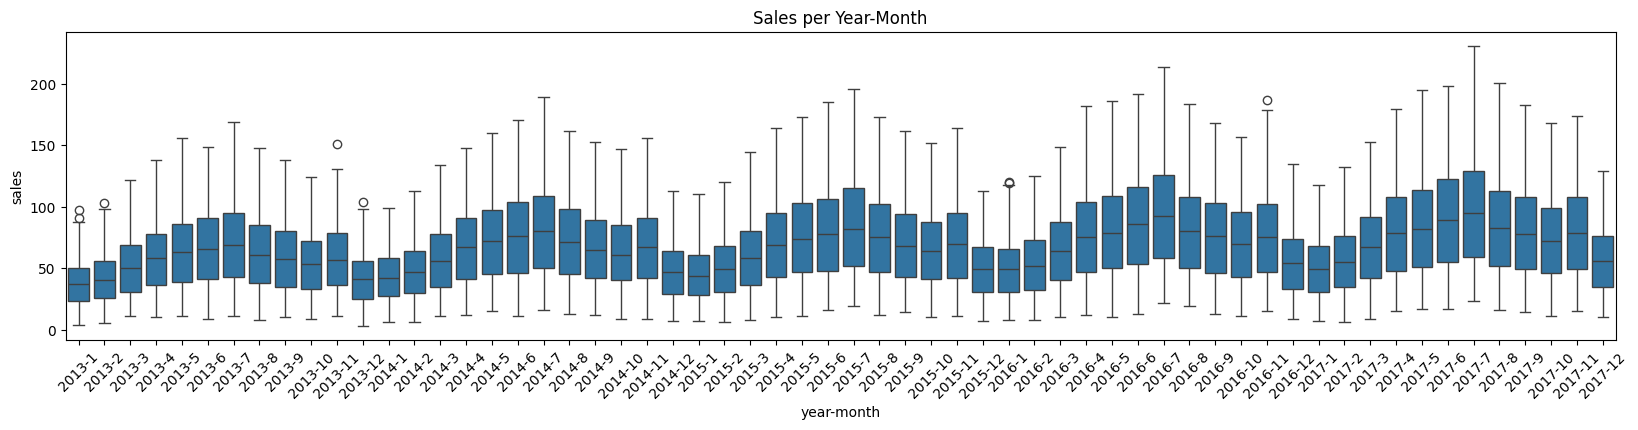

In [24]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
plt.title('Sales per Year-Month')
sns.boxplot(x="year-month", y="sales", data=df_store_2)


Pola penjualan per bulan terlihat cukup konsisten setiap tahunnya.

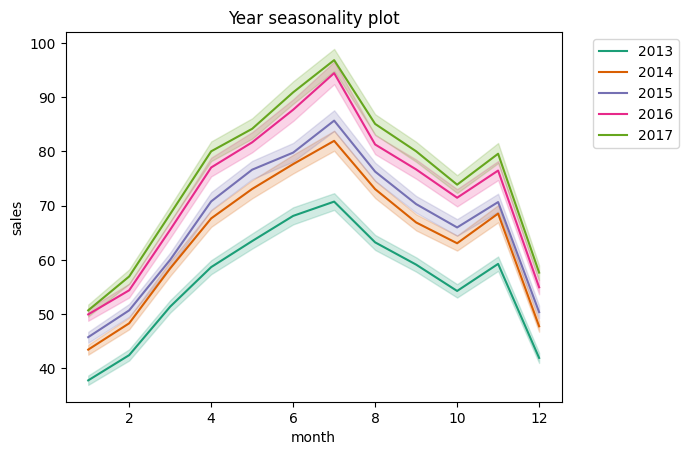

In [25]:
sns.lineplot(data=df_store_2,
             x='month',
             y='sales',
             hue='year',
             legend='full',
            palette='Dark2')

# add title
plt.title('Year seasonality plot')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Perilaku penjualan hampir sama setiap tahun dengan jumlah penjualan yang lebih tinggi pada bulan Juli. Selain itu, data menunjukkan bahwa volume penjualan meningkat setiap tahun. Menarik untuk dicatat bahwa tahun 2014 dan 2015 tampaknya memiliki jumlah penjualan yang mirip. Hal yang sama juga diamati pada tahun 2016 dan 2017.

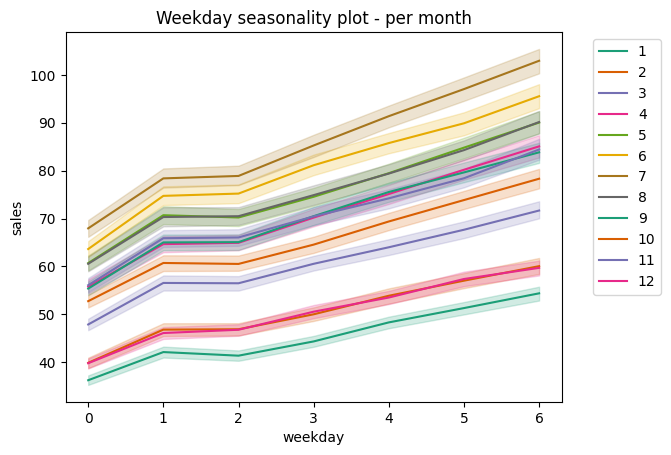

In [26]:
sns.lineplot(data=df_store_2,
             x='weekday',
             y='sales',
             hue='month',
             legend='full',
            palette='Dark2')

# add title
plt.title('Weekday seasonality plot - per month')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Plot ini menunjukkan bahwa nilai penjualan yang lebih tinggi selama akhir pekan serta bulan Juli sebagai bulan dengan penjualan terbanyak.

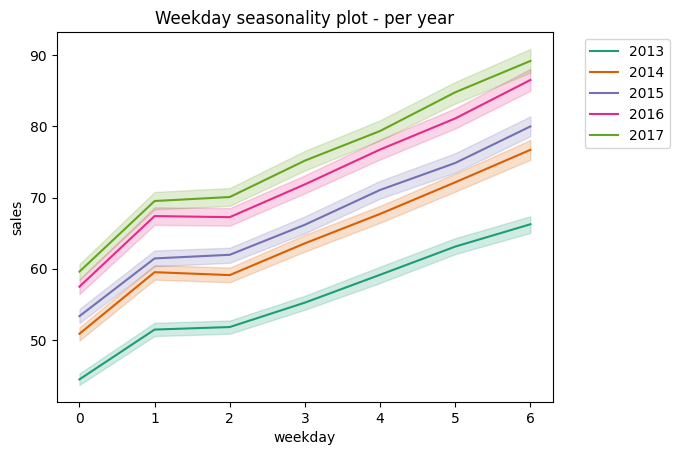

In [27]:
sns.lineplot(data=df_store_2,
             x='weekday',
             y='sales',
             hue='year',
             legend='full',
            palette='Dark2')

# add title
plt.title('Weekday seasonality plot - per year')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Di sini juga terlihat bahwa jumlah penjualan yang lebih tinggi selama akhir pekan. Selain itu, peningkatan penjualan setiap tahun dengan tahun 2014 dan 2015 memiliki jumlah penjualan yang mirip, begitu pula dengan tahun 2016 dan 2017.

In [28]:
df_store_2_item_28 = df_store_2[['date','sales']][df_store_2['item']==1].reset_index(drop=True)
df_store_2_item_28.head()

,date,sales
0,2013-01-01,12
1,2013-01-02,16
2,2013-01-03,16
3,2013-01-04,20
4,2013-01-05,16


In [29]:
df_store_2_item_28.tail()

,date,sales
1821,2017-12-27,19
1822,2017-12-28,21
1823,2017-12-29,18
1824,2017-12-30,24
1825,2017-12-31,31


In [30]:
# save data in csv

df_store_2_item_28.to_csv("sales_store_2_item_28.csv", index=False)

In [31]:
# set date as index
df_store_2_item_28_time = df_store_2_item_28.set_index('date')

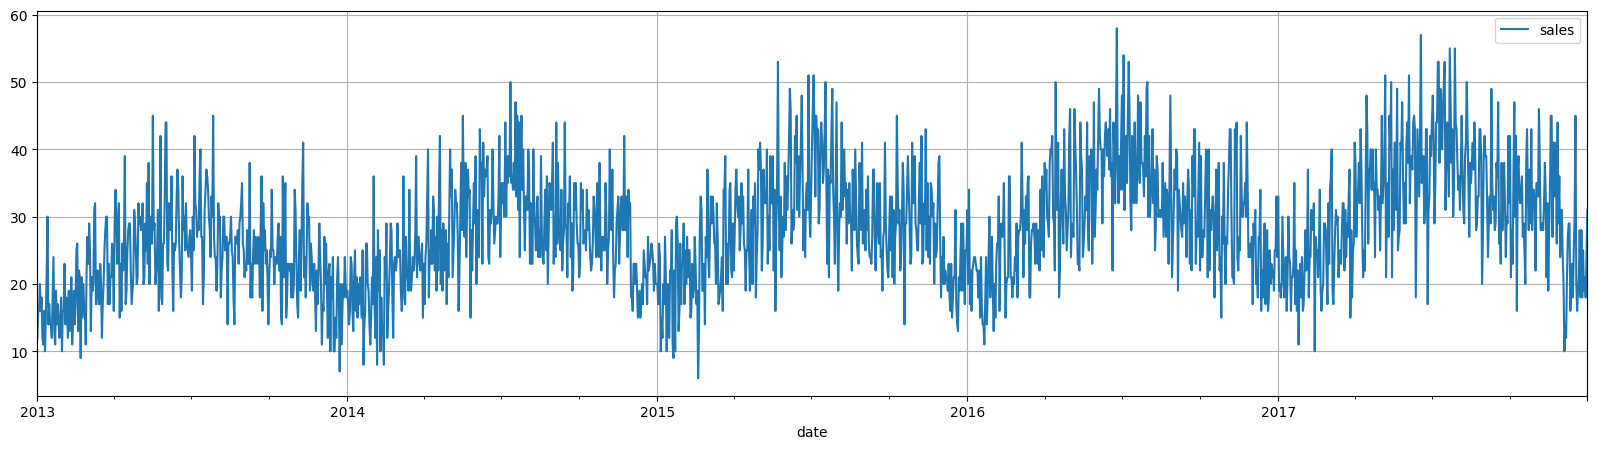

In [32]:
# Plot the entire time series diet and show gridlines
df_store_2_item_28_time.plot(grid=True,figsize=(20,5))
plt.show()

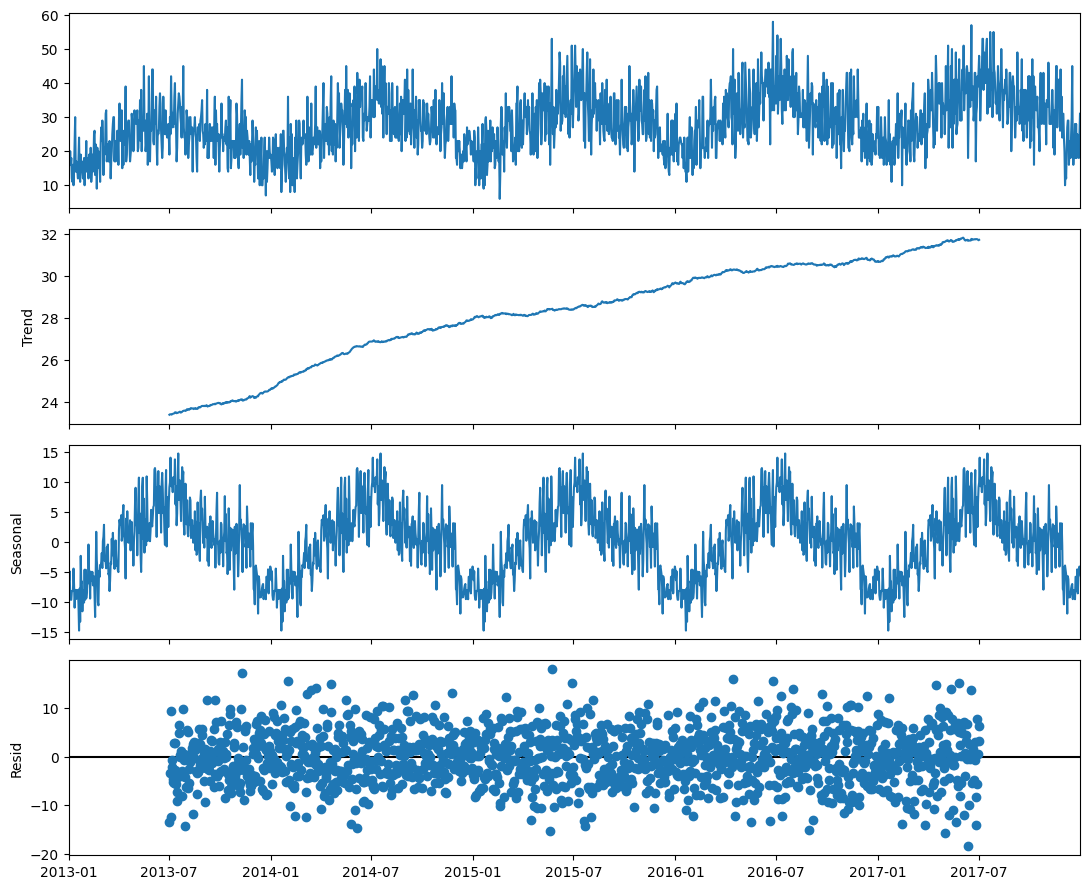

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time,
                                          model = 'additive',
                                          period=365, # cycle repeats 365 days, i.e., every year
                                         )
fig = decomposition.plot()
plt.show()

Dari dekomposisi di atas, dapat disimpulkan:

1. Terdapat tren naik pada penjualan. Oleh karena itu, deret waktu ini tidak stasioner.
2. Dari komponen musiman, dapat diamati bahwa model ini aditif, karena komponen musiman serupa sepanjang waktu.
3. Juga dapat diamati pada komponen musiman dalam penjualan dengan penjualan lebih rendah pada bulan Januari dan penjualan lebih tinggi pada bulan Juli.

Karena data kita tidak stasioner, akan digunakan fungsi `obtain_adf_kpss_results` untuk mengetahui berapa kali perlu menerapkan differencing agar deret waktu ini menjadi stasioner. Yang akan menjadi parameter `d` untuk model ARIMA.

### Uji Stasionaritas

In [34]:
obtain_adf_kpss_results(df_store_2_item_28_time,3)

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,3.804258e-02,0.01,True,False,False
1,1,8.084986e-22,0.10,True,True,True
2,2,1.151984e-27,0.10,True,True,True


`d=1`, menerapkan differencing satu kali saja sudah cukup untuk membuat deret waktu kita menjadi stasioner.

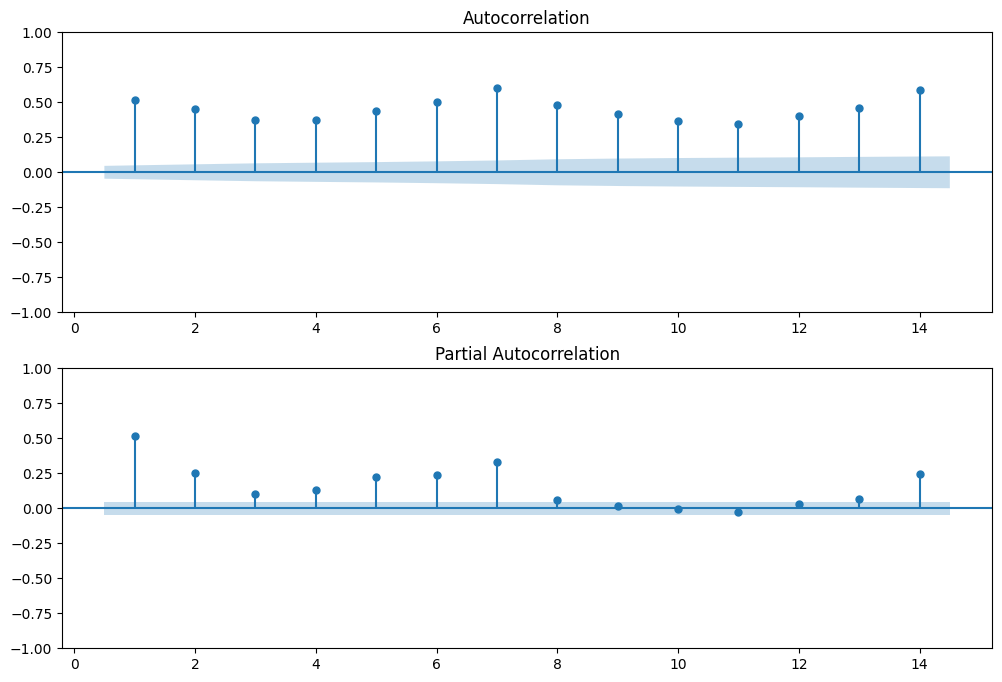

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_store_2_item_28_time,lags=14, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_store_2_item_28_time,lags=14, zero=False, ax=ax2)

plt.show()

ACF di atas menunjukkan pola korelasi periodik. Untuk menemukan periode, kita mencari lag lebih besar dari satu yang merupakan puncak di plot ACF. Di sini, terdapat puncak pada lag ke-7, yaitu komponen musiman berulang setiap 7 langkah (satu minggu).

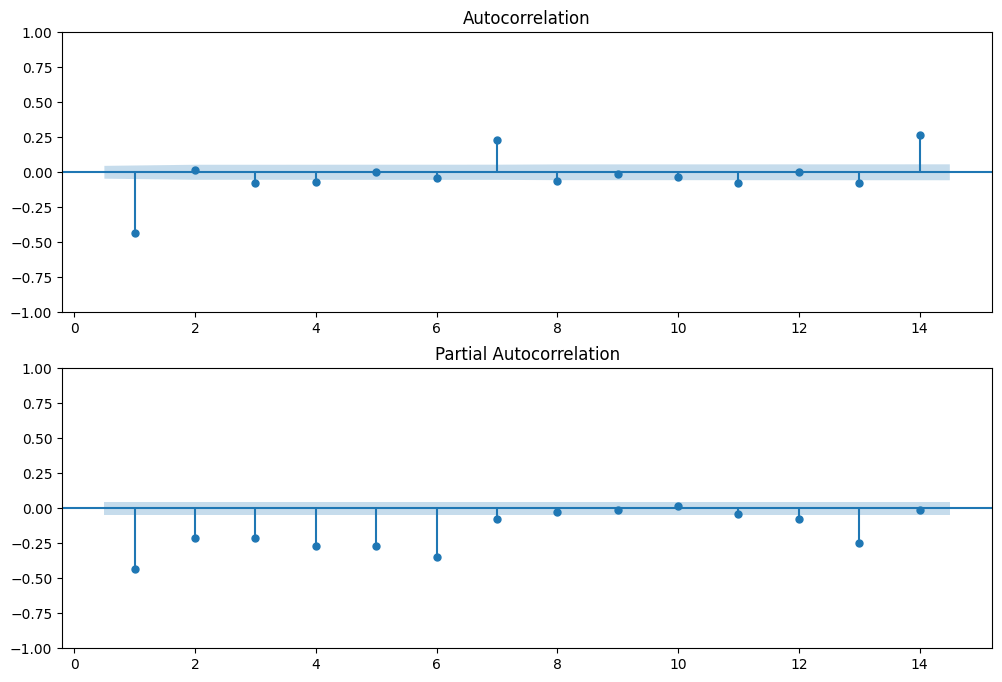

In [36]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_store_2_item_28_time.diff().dropna(),lags=14, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_store_2_item_28_time.diff().dropna(),lags=14, zero=False, ax=ax2)

plt.show()

Dengan mengamati plot ACF dan PACF setelah membuat deret waktu menjadi stasioner, tidak terlihat pola yang jelas pada kedua plot tersebut.

Dari plot tersebut juga dapat disimpulkan bahwa terdapat perilaku musiman dengan periode 7 yang ditunjukkan oleh puncak pada lag ke-7, 14, 21, dan seterusnya (setiap minggu). Ini menunjukkan perlunya istilah musiman dalam model ARIMA kita. Dengan kata lain, kita memerlukan model SARIMA.

### Model SARIMA

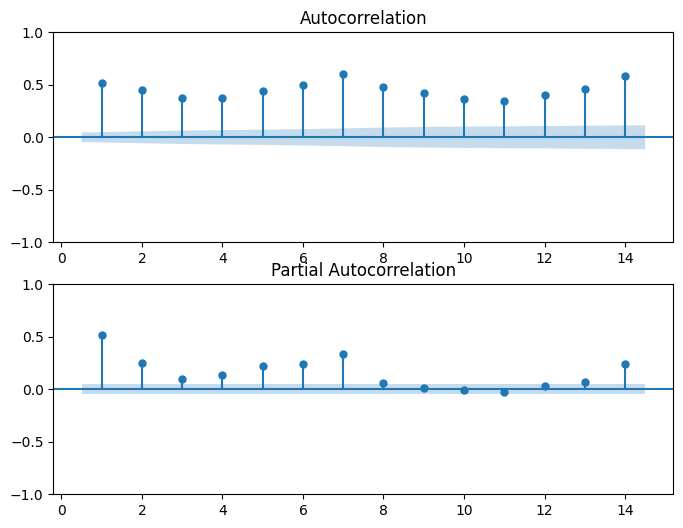

In [37]:
# Create the figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time, lags=14, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time, lags=14, zero=False, ax=ax2)

plt.show()

In [38]:
# Take the first and seasonal differences (S=7) and drop NaNs
df_store_2_item_28_time_diff = df_store_2_item_28_time.diff().diff(7).dropna()

Untuk data musiman dilakukan hal yang sama :

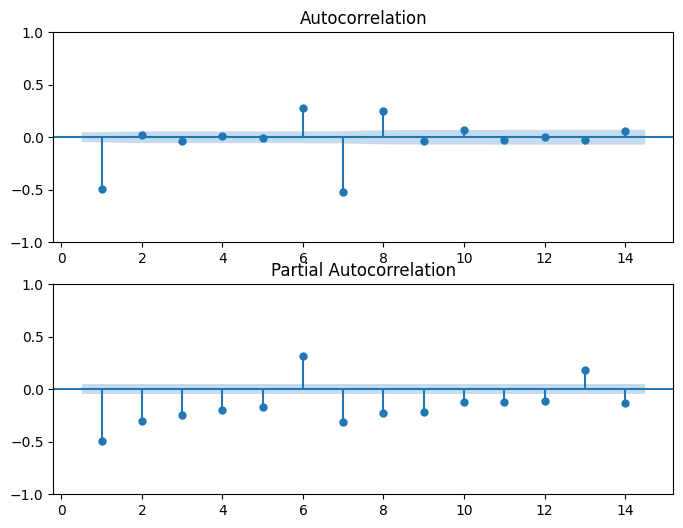

In [39]:
# Create the figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time_diff, lags=14, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time_diff, lags=14, zero=False, ax=ax2)

plt.show()

Plot ACF dan PACF non-musiman di atas menunjukkan pola model MA dengan `q=1`.

Untuk bagian musiman, kita mengatur parameter lag ke daftar lag tertentu, bukan ke maksimum, kemudian memplot ACF dan PACF hanya untuk lag-lag tersebut.

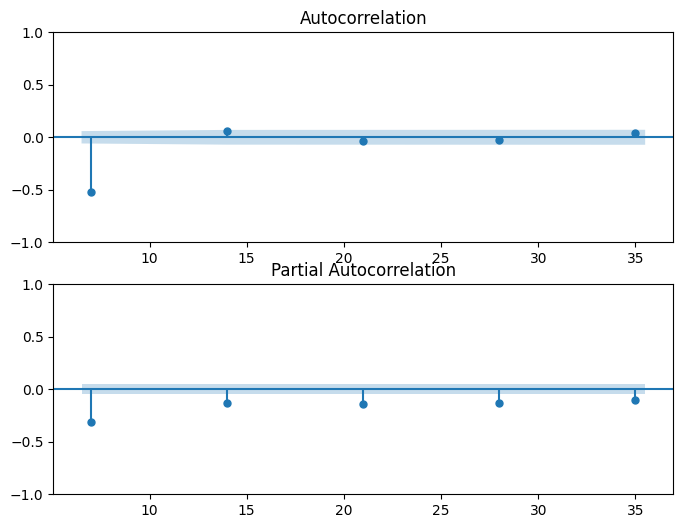

In [40]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time_diff, lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time_diff, lags=lags, zero=False, ax=ax2)

plt.show()

Plot ACF dan PACF musiman tampak seperti model MA(1), yaitu, Q=1. Kita dapat memilih model yang menggabungkan keduanya, yaitu, SARIMA $(0,1,6)(0,1,1)_7$.

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
sarima_01_model = SARIMAX(df_store_2_item_28_time, order=(0,1,6), seasonal_order=(0,1,1,7))
sarima_01_results = sarima_01_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_01_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 4.555


In [43]:
sarima_01_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1826
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -5734.902
Date:                             Wed, 26 Jun 2024   AIC                          11485.804
Time:                                     17:23:17   BIC                          11529.848
Sample:                                 01-01-2013   HQIC                         11502.054
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8688      0.023    -37.673      0.000      -0.914      -0.824
ma.L2          0.0019      0.032      0.060      0.952      -0.061       0.065
ma.L3         -0.0070      0.033     -0.216      0.829      -0.071       0.057
ma.L4          0.0082      0.030      0.270      0.787      -0.051       0.068
ma.L5         -0.0022      0.030     -0.072      0.942      -0.062       0.057
ma.L6         -0.0064      0.024     -0.268      0.789      -0.054       0.041
ma.S.L7       -0.9915      0.007   -150.225      0.000      -1.004      -0.979
sigma2        31.6282      1.096     28.847      0.000      29.479      33.777
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.15
Prob(Q):                              0.97   Prob(JB):                         0.13
Heteroskedasticity (H):               1.31   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cara lain untuk menentukan parameter model adalah metode empiris dengan mempertimbangkan nilai AIC dan BIC. Namun, sekarang kita memiliki lebih banyak parameter yang perlu dipertimbangkan. Dalam kasus ini, penggunaan `Automated Model Selection` bisa sangat berguna.

Prob(Q) = 0.97 > 0.05. Kita sebaiknya tidak menolak hipotesis nol bahwa residual tidak berkorelasi sehingga `residual tidak berkorelasi`.

Prob(JB) = 0.13 > 0.05. Kita sebaiknya tidak menolak hipotesis nol bahwa residual berdistribusi normal. Oleh karena itu, residual `berdistribusi normal`.

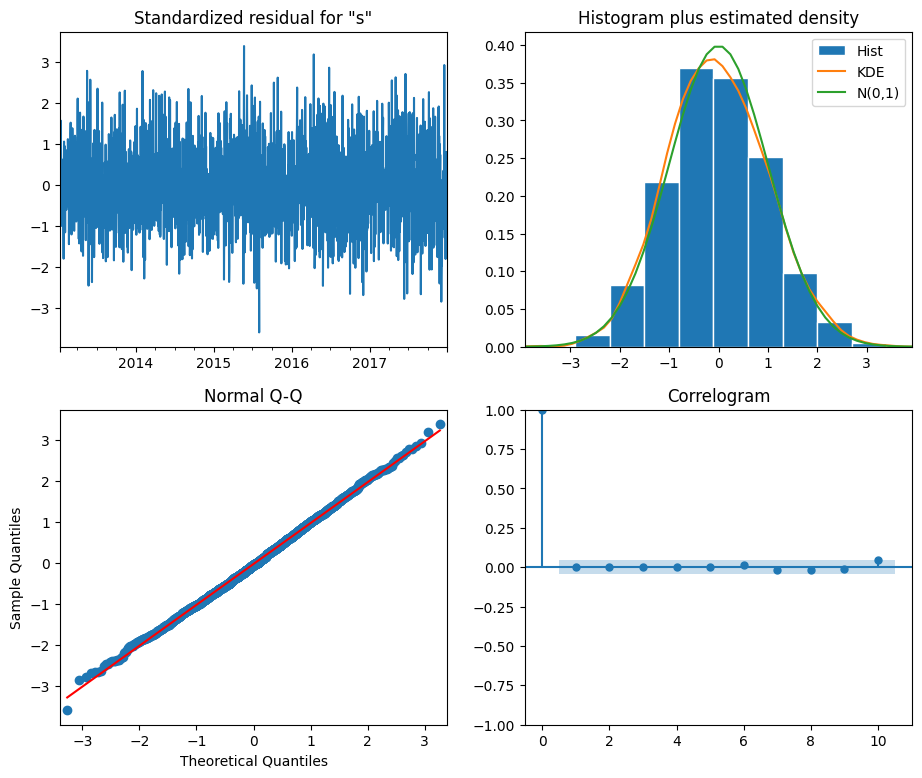

In [44]:
sarima_01_results.plot_diagnostics()
plt.show()

* **Residual Terstandarisasi**: Tidak menunjukkan pola yang jelas pada residual. Ini menunjukkan model yang baik.

* **Histogram dan Estimasi KDE**: Kurva oranye mirip dengan kurva hijau.

* **Korelogram** atau plot ACF: 95% dari korelasi untuk lag lebih besar dari satu seharusnya tidak signifikan (di dalam area biru). Ini juga terjadi, yaitu menunjukkan model yang baik.

* **Normal Q-Q**: Sebagian besar titik data harus terletak di garis lurus, kecuali titik-titik di ujung. Ini menunjukkan distribusi normal dari residual.

### Automated Model Selection


In [45]:
df_store_2_item_28_time.head()

,sales
date,
2013-01-01,12
2013-01-02,16
2013-01-03,16
2013-01-04,20
2013-01-05,16


In [46]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df_store_2_item_28_time, 
                      seasonal=True, 
                      m=7, 
                      d=1, 
                      D=1, 
                 	  max_p=6, 
                      max_q=6, 
                      max_P=6, 
                      max_Q=6, 
                      information_criterion='aic', 
                      trace=True, 
                      error_action='ignore', 
                      stepwise=True, 
                      suppress_warnings=True)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=4.79 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=13739.527, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=12650.572, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=13229.902, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=12480.179, Time=0.53 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=12344.238, Time=1.07 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=12270.400, Time=1.89 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=12224.430, Time=2.56 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=12196.670, Time=4.78 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=inf, Time=21.77 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=16.68 sec
 ARIMA(0,1,0)(6,1,0)[7]             : AIC=12702.277, Time=3.18 sec
 ARIMA(2,1,0)(6,1,0)[7]             : AIC=11998.566, Time=3.94 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC

Pemilihan model otomatis memilih SARIMA $(6,1,1)(6,1,0)_7$ sebagai model terbaik berdasarkan AIC.

In [ ]:
sarima_02_model = SARIMAX(df_store_2_item_28_time, order=(6,1,1), seasonal_order=(6,1,0,7))
sarima_02_results = sarima_02_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

Nilai ini sedikit lebih tinggi dibandingkan dengan nilai yang diperoleh oleh model sebelumnya.

In [ ]:
sarima_02_results.summary()

Prob(Q) = 1.00 > 0.05. Kita sebaiknya tidak menolak hipotesis nol bahwa residual tidak berkorelasi sehingga `residual tidak berkorelasi`.

Prob(JB) = 0.98 > 0.05. Kita sebaiknya tidak menolak hipotesis nol bahwa residual berdistribusi normal. Oleh karena itu, residual `berdistribusi normal`.

In [ ]:
# Create the 4 diagostics plots
sarima_02_results.plot_diagnostics()
plt.show()

# Forecasting
Akan dilakukan peramalan menggunakan model SARIMA terbaik. Untuk menilai seberapa baik model yang dipilih, akan digunakan data 90 hari terakhir sebagai dataset validasi.

In [ ]:
sarima_01_results.summary()

In [ ]:
sarima_02_results.summary()

Ketiga model tampaknya tidak menunjukkan korelasi dalam residual. Model ARIMA adalah satu-satunya yang menolak hipotesis Jarque-Bera (Prob(JB) < 0.05). Oleh karena itu, untuk model ini, residual tidak berdistribusi normal.

In [ ]:
# Create SARIMA mean forecast
sarima_01_pred = sarima_01_results.get_prediction(start=-90, dynamic=True)
sarima_01_mean = sarima_01_pred.predicted_mean

# Create SARIMA mean forecast
sarima_02_pred = sarima_02_results.get_prediction(start=-90, dynamic=True)
sarima_02_mean = sarima_02_pred.predicted_mean

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
metrics_sarima_01 = [round(mean_absolute_error(df_store_2_item_28_time[-90:],sarima_01_mean),3),
                       round(mean_absolute_percentage_error(df_store_2_item_28_time[-90:],sarima_01_mean),3)]

In [ ]:
metrics_sarima_02 = [round(mean_absolute_error(df_store_2_item_28_time[-90:],sarima_02_mean),3),
                       round(mean_absolute_percentage_error(df_store_2_item_28_time[-90:],sarima_02_mean),3)]

In [ ]:
df_sarima_results = pd.DataFrame({'metrics':['MAE','MAPE'],
              'SARIMA(0,1,6)(0,1,1)7':metrics_sarima_01,
              'SARIMA(6,1,1)(6,1,0)7':metrics_sarima_02,
             })

df_sarima_results

In [ ]:
# save results in csv

df_sarima_results.to_csv("../data/processed/results_arima.csv", index=False)

Model SARIMA kedua, yang dipilih oleh pemilihan model otomatis, menunjukkan nilai terbaik untuk metrik yang dipertimbangkan.

In [ ]:
dates = df_store_2_item_28_time.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.figure(figsize=(15,10))
plt.title('Comparing forecasting in sample of all models', size = 16)
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(0,1,6)(0,1,1)7')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMAX(6,1,1)(6,1,0)7')
plt.plot(df_store_2_item_28_time[-90:], label='observed')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(0,1,6)(0,1,1)7', size = 16)
plt.plot(df_store_2_item_28_time[-90:], label='observed', color='red')
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(0,1,6)(0,1,1)7', color='orange')


In [ ]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(6,1,1)(6,1,0)7 (obtained by using automated selection)', size = 16)
plt.plot(df_store_2_item_28_time[-90:], label='observed', color='red')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMA(6,1,1)(6,1,0)7', color='green')


Perhatikan bagaimana hasil model SARIMA(6,1,1)(6,1,0)\(_7\) (garis hijau) lebih mengikuti kurva merah (nilai teramati) dibandingkan dengan model ARIMA (garis biru) dan model SARIMA lainnya (SARIMA(0,1,6)(0,1,1)\(_7\), garis oranye).

### Peramalan

Untuk prediksi 90 hari ke depan, kita hanya akan menggunakan model ARIMA (ARIMAX(4,1,5)) dan model SARIMA yang dipilih oleh pemilihan model otomatis: SARIMA(6,1,1)x(6,1,0)\(_7\).

In [ ]:
# Create SARIMA mean forecast
sarima_02_pred = sarima_02_results.get_forecast(steps=90)
sarima_02_mean = sarima_02_pred.predicted_mean

In [ ]:
# SARIMA predictions
sarima_02_mean

In [ ]:
dates = df_store_2_item_28_time.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.title("Forecasting 90 days ahead - SARIMA", size =16)
plt.plot(df_store_2_item_28_time['2017':], label='observed')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMA(6,1,1)(6,1,0)7')
plt.legend()
plt.show()

### Saving Model

In [ ]:
# Import joblib
import joblib

# Set model name
filename = "../model/store_2_item_28_model.pkl"

# Pickle it
joblib.dump(sarima_02_model,filename)


In [ ]:
filename = "../model/store_2_item_28_model.pkl"
loaded_model = joblib.load(filename)

In [ ]:
loaded_model.fit().summary()